## Exercise 2: Bias-variance trade-off and resampling techniques 

#### Overview of nature of the problem: 



In [1]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import common
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
np.random.seed(4155)
maxdegree = 12
n = 400
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
z = common.FrankeFunction(x, y) + 0.2*np.random.normal(0, size = n)

Looping through polynomials up to 400 degrees with 1000 bootstraps: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


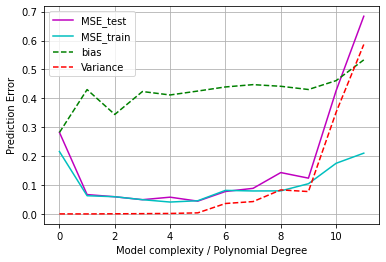

In [3]:
#TODO: Number of bootstraps? 
n_boostraps = 1000
MSE_test = np.zeros(maxdegree)
MSE_train = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
#for each degree of poly:


for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {n} degrees with {n_boostraps} bootstraps: "):
    model = LinearRegression()
    #model= make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)) 
    X = common.create_X(x, y, n=degree)    
    X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2)

    #reshape for broadcasting in MSE_test and MSE_val  
    y_test_ = np.reshape(y_test, newshape=(y_test.shape[0],1))
    #reshape for broadcasting in MSE_test and MSE_val  
    y_train_ = np.reshape(y_train, newshape=(y_train.shape[0],1))

    #y_train = np.reshape(y_train, newshape=(y_train.shape[0],1))
    #TODO: why scale?!?

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    y_fit = np.empty((y_train.shape[0], n_boostraps))
    
    for i in range(n_boostraps):
        #bootstrap:
        x_, y_ = resample(X_train_scaled, y_train)
        #fit model to x_,y_ sample:
        #print(f"y_.shape : {y_.shape}")
        clf =  model.fit(x_, y_)
        #fit model and predict on test data:
        y_pred[:, i] = clf.predict(X_test_scaled)
        #predict on train data:
        y_fit[:,i] = clf.predict(X_train_scaled)
        

    polydegree[degree] = degree
   
    MSE_test[degree] = np.mean( np.mean((y_test_ - y_pred)**2, axis=1, keepdims=True) )
    MSE_train[degree] = np.mean( np.mean((y_train_ - y_fit)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True))
    
plt.plot(polydegree, MSE_test,"m", label='MSE_test')
plt.plot(polydegree, MSE_train,"c", label='MSE_train')

plt.plot(polydegree, bias,"g--", label='bias')
plt.plot(polydegree, variance,"r--", label='Variance')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error")

plt.grid(True)
plt.legend()
plt.show()